In [12]:
import os, glob, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans as SKLearnKMeans
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting (no direct use)
np.random.seed(42)

candidates = []

search_dirs = [".", "/content", "/mnt/data"]
for d in search_dirs:
    for pattern in ["Mall_Customers.*", "Mall_Customers*.*", "Mall_customers*.*", "Mall Customers*.*", "Mall-Customers*.*"]:
        candidates.extend(glob.glob(os.path.join(d, pattern)))

candidates = list(dict.fromkeys(candidates))  # unique
if not candidates:
    raise FileNotFoundError("Dataset file not found. Please upload 'Mall_Customers.xls' or 'Mall_Customers.csv' to Colab (Files pane) and rerun.")

print("Found dataset file(s):", candidates)
# choose the first match
file_path = candidates[0]
print("Using:", file_path)

Found dataset file(s): ['./Mall_Customers.xls', '/content/Mall_Customers.xls']
Using: ./Mall_Customers.xls


In [13]:
def try_load(path):
    # try CSV, then excel engines
    try:
        df = pd.read_csv(path)
        print("Loaded as CSV.")
        return df
    except Exception as e_csv:
        # try excel engines
        for engine in ("xlrd","openpyxl","odf","pyxlsb"):
            try:
                df = pd.read_excel(path, engine=engine)
                print(f"Loaded as Excel with engine='{engine}'.")
                return df
            except Exception:
                pass
        # final try pandas autodetect
        try:
            df = pd.read_excel(path)
            print("Loaded as Excel (autodetect).")
            return df
        except Exception as e_final:
            # raise informative error
            raise ValueError(f"Could not read file as CSV or Excel. CSV error: {e_csv}; final Excel error: {e_final}")

df = try_load(file_path)
print("Dataset shape:", df.shape)
display(df.head())


print("\n--- Columns ---")
print(df.columns.tolist())

print("\n--- Missing values per column ---")
print(df.isna().sum())

Loaded as CSV.
Dataset shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40



--- Columns ---
['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

--- Missing values per column ---
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64



Detected columns -> Age: Age Income: Annual Income (k$) SpendingScore: Spending Score (1-100)

Selected features for clustering: ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
Shape after dropping NA in selected features: (200, 3)


,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


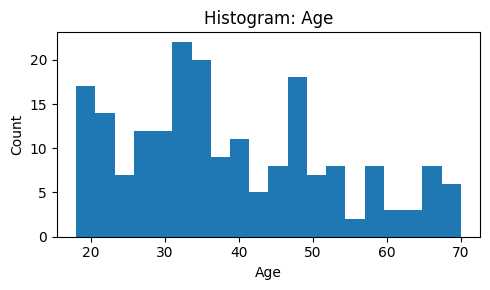

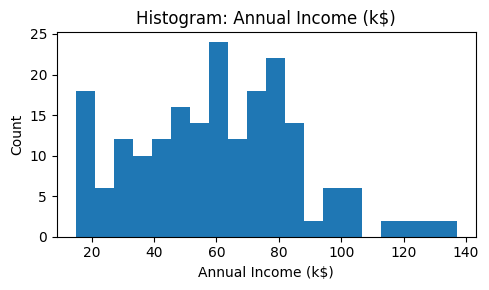

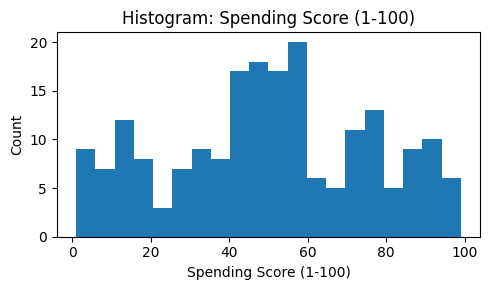

<Figure size 700x700 with 0 Axes>

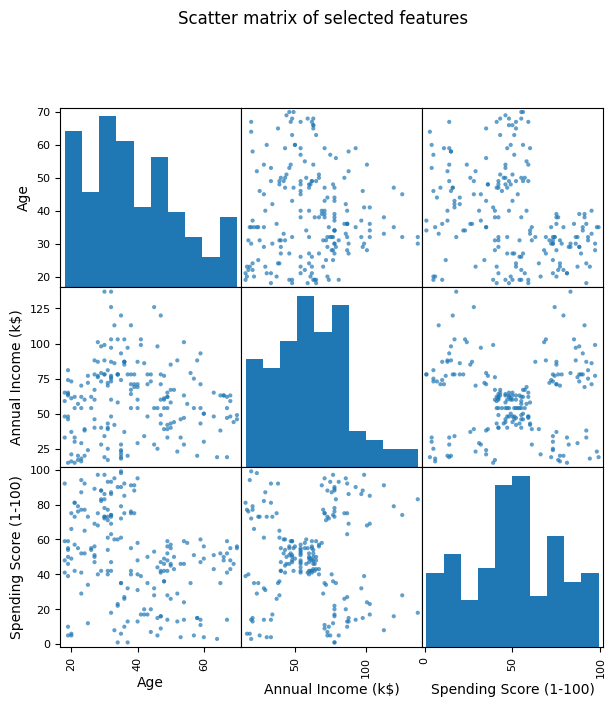

In [14]:
col_map = {c.lower(): c for c in df.columns}
def find_col(keyword_list):
    for kw in keyword_list:
        for k in col_map:
            if kw in k:
                return col_map[k]
    return None

age_col = find_col(["age"])
income_col = find_col(["annual income", "annual_income", "income"])
score_col = find_col(["spending score", "spending_score", "score"])
print("\nDetected columns -> Age:", age_col, "Income:", income_col, "SpendingScore:", score_col)

if not (age_col and income_col and score_col):

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if "id" not in c.lower()]
    if len(numeric_cols) >= 3:
        age_col, income_col, score_col = numeric_cols[:3]
        print("Fallback numeric columns used:", age_col, income_col, score_col)
    else:
        raise ValueError("Could not identify 3 numeric columns for Age, Income, SpendingScore.")

selected = [age_col, income_col, score_col]
print("\nSelected features for clustering:", selected)


X_raw = df[selected].copy().dropna().reset_index(drop=True)
print("Shape after dropping NA in selected features:", X_raw.shape)
display(X_raw.describe())

# Histograms
for col in selected:
    plt.figure(figsize=(5,3))
    plt.hist(X_raw[col], bins=20)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Scatter matrix
plt.figure(figsize=(7,7))
scatter_matrix(X_raw, alpha=0.7, diagonal='hist', figsize=(7,7))
plt.suptitle("Scatter matrix of selected features", y=1.02)
plt.show()

In [15]:
#  Standardization (justification printed)

print("\nStandardization justification:")
print("- K-Means uses Euclidean distance. Features are on different scales (years, k$, 1-100).")
print("- StandardScaler (z-score) centers to mean 0 and std 1 to prevent a large-scale feature dominating distances.\n")

scaler = StandardScaler()
X = scaler.fit_transform(X_raw.values)
print("Standardized data shape:", X.shape)


print("First 3 standardized rows:")
print(X[:3])

#  Implement K-Means from scratch (random and kmeans++)

def initialize_centroids_random(X, k, random_state=None):
    rng = np.random.RandomState(random_state)
    idx = rng.choice(X.shape[0], size=k, replace=False)
    return X[idx].copy()

def initialize_centroids_kmeanspp(X, k, random_state=None):
    rng = np.random.RandomState(random_state)
    n = X.shape[0]
    centers = []
    first = rng.randint(0, n)
    centers.append(X[first].copy())
    for _ in range(1, k):

        dists = np.array([min(np.sum((x - c)**2) for c in centers) for x in X])
        total = dists.sum()
        if total == 0:
            probs = np.ones(n) / n
        else:
            probs = dists / total
        next_idx = rng.choice(n, p=probs)
        centers.append(X[next_idx].copy())
    return np.vstack(centers)

def assign_clusters(X, centroids):

    dists = np.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2) # (n_samples, k)
    labels = np.argmin(dists, axis=1)
    min_sq = np.min(dists, axis=1)**2
    return labels, min_sq

def update_centroids(X, labels, k):
    n_features = X.shape[1]
    centroids = np.zeros((k, n_features))
    for i in range(k):
        pts = X[labels == i]
        if len(pts) == 0:

            centroids[i] = X[np.random.randint(0, X.shape[0])]
        else:
            centroids[i] = pts.mean(axis=0)
    return centroids

def compute_inertia(X, centroids, labels):
    return np.sum(np.linalg.norm(X - centroids[labels], axis=1)**2)

def kmeans_from_scratch(X, k, init='kmeans++', max_iters=300, tol=1e-4, random_state=None, verbose=False):
    if init == 'random':
        centroids = initialize_centroids_random(X, k, random_state=random_state)
    elif init == 'kmeans++':
        centroids = initialize_centroids_kmeanspp(X, k, random_state=random_state)
    else:
        raise ValueError("init must be 'random' or 'kmeans++'")

    for it in range(1, max_iters+1):
        labels, _ = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        shift = np.linalg.norm(new_centroids - centroids)
        centroids = new_centroids
        if verbose:
            print(f"Iter {it}, shift {shift:.6f}")
        if shift < tol:
            break
    inertia = compute_inertia(X, centroids, labels)
    return centroids, labels, it, inertia


Standardization justification:
- K-Means uses Euclidean distance. Features are on different scales (years, k$, 1-100).
- StandardScaler (z-score) centers to mean 0 and std 1 to prevent a large-scale feature dominating distances.

Standardized data shape: (200, 3)
First 3 standardized rows:
[[-1.42456879 -1.73899919 -0.43480148]
 [-1.28103541 -1.73899919  1.19570407]
 [-1.3528021  -1.70082976 -1.71591298]]



Comparing initialization methods with k=5 over 10 runs...
Random init: avg inertia=171.242, avg iters=8.20
KMeans++:    avg inertia=175.106, avg iters=8.40
k=2: inertia=389.39, silhouette=0.3355
k=3: inertia=296.08, silhouette=0.3546
k=4: inertia=205.23, silhouette=0.4040
k=5: inertia=168.76, silhouette=0.4104
k=6: inertia=133.87, silhouette=0.4274
k=7: inertia=117.01, silhouette=0.4172
k=8: inertia=105.64, silhouette=0.4215
k=9: inertia=101.41, silhouette=0.3807
k=10: inertia=97.55, silhouette=0.3785


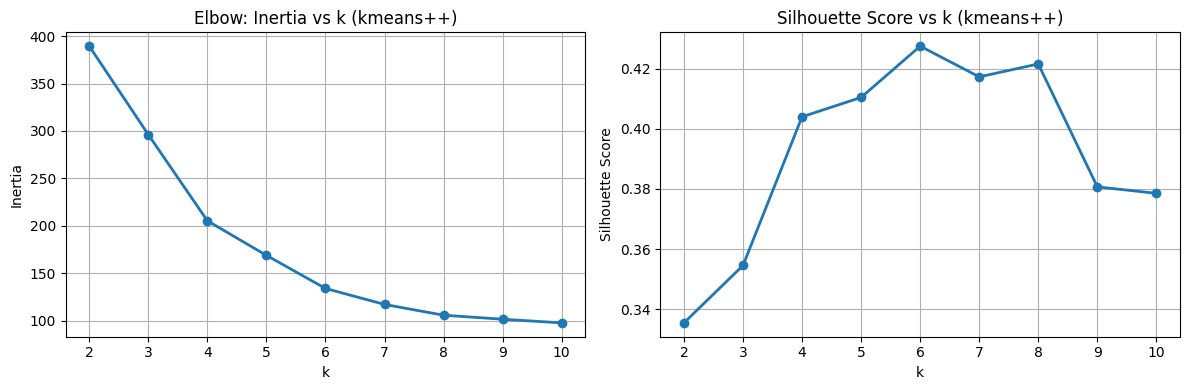


Best k by silhouette score = 6
Inertia decreases between consecutive k: [-93.31 -90.85 -36.46 -34.89 -16.86 -11.37  -4.23  -3.86]
Heuristic elbow suggestion (approx): k = 9
Chosen final_k = 6 (silhouette) ; elbow suggestion ~ 9


In [16]:
def compare_initializations(X, k, n_runs=10, seed=42):
    rng = np.random.RandomState(seed)
    rand_inertias = []
    rand_iters = []
    pp_inertias = []
    pp_iters = []
    for run in range(n_runs):
        s = int(rng.randint(0, 100000))
        _, _, it_r, in_r = kmeans_from_scratch(X, k, init='random', random_state=s)
        _, _, it_pp, in_pp = kmeans_from_scratch(X, k, init='kmeans++', random_state=s)
        rand_inertias.append(in_r)
        rand_iters.append(it_r)
        pp_inertias.append(in_pp)
        pp_iters.append(it_pp)
    return {
        'random': {'inertias': rand_inertias, 'iters': rand_iters},
        'kmeans++': {'inertias': pp_inertias, 'iters': pp_iters}
    }


demo_k = 5
print(f"\nComparing initialization methods with k={demo_k} over 10 runs...")
cmp_res = compare_initializations(X, demo_k, n_runs=10, seed=123)
print("Random init: avg inertia={:.3f}, avg iters={:.2f}".format(np.mean(cmp_res['random']['inertias']), np.mean(cmp_res['random']['iters'])))
print("KMeans++:    avg inertia={:.3f}, avg iters={:.2f}".format(np.mean(cmp_res['kmeans++']['inertias']), np.mean(cmp_res['kmeans++']['iters'])))


#  Elbow and Silhouette: choose k (k=2..10)

ks = list(range(2, 11))
inertias_kpp = []
sil_scores = []
run_seed = 42
for k in ks:

    cent, labels, iters, inert = kmeans_from_scratch(X, k, init='kmeans++', random_state=run_seed)
    inertias_kpp.append(inert)
    sil = silhouette_score(X, labels)
    sil_scores.append(sil)
    print(f"k={k}: inertia={inert:.2f}, silhouette={sil:.4f}")

fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].plot(ks, inertias_kpp, 'o-', linewidth=2)
axes[0].set_title("Elbow: Inertia vs k (kmeans++)")
axes[0].set_xlabel("k"); axes[0].set_ylabel("Inertia")
axes[0].grid(True)

axes[1].plot(ks, sil_scores, 'o-', linewidth=2)
axes[1].set_title("Silhouette Score vs k (kmeans++)")
axes[1].set_xlabel("k"); axes[1].set_ylabel("Silhouette Score")
axes[1].grid(True)

plt.tight_layout()
plt.show()

best_k_sil = ks[int(np.argmax(sil_scores))]
print(f"\nBest k by silhouette score = {best_k_sil}")

inert_drops = np.diff(inertias_kpp)
print("Inertia decreases between consecutive k:", np.round(inert_drops,2))

second_diff = np.diff(inertias_kpp, n=2)
if len(second_diff)>0:
    elbow_suggest = ks[int(np.argmin(second_diff))+1]  # heuristic
    print("Heuristic elbow suggestion (approx): k =", elbow_suggest)
else:
    elbow_suggest = None


final_k = best_k_sil
print(f"Chosen final_k = {final_k} (silhouette) ; elbow suggestion ~ {elbow_suggest}")



Running final K-Means (k=6) with kmeans++ init...
Iter 1, shift 1.067905
Iter 2, shift 0.328096
Iter 3, shift 0.178516
Iter 4, shift 0.130751
Iter 5, shift 0.103803
Iter 6, shift 0.163944
Iter 7, shift 0.298990
Iter 8, shift 0.209839
Iter 9, shift 0.051937
Iter 10, shift 0.000000
Completed in 10 iterations, inertia=133.868, time=0.023s

Final centroids (original units):


,Age,Annual Income (k$),Spending Score (1-100),cluster
0,56.333333,54.266667,49.066667,0
1,32.692308,86.538462,82.128205,1
2,25.250000,25.833333,76.916667,2
3,41.939394,88.939394,16.969697,3
4,26.684211,57.578947,47.789474,4
5,45.523810,26.285714,19.380952,5



Cluster sizes:


,cluster,size
0,0,45
1,1,39
2,2,24
3,3,33
4,4,38
5,5,21



Cluster averages (original units):


,cluster,Age,Annual Income (k$),Spending Score (1-100)
0,0,56.333333,54.266667,49.066667
1,1,32.692308,86.538462,82.128205
2,2,25.250000,25.833333,76.916667
3,3,41.939394,88.939394,16.969697
4,4,26.684211,57.578947,47.789474
5,5,45.523810,26.285714,19.380952



Business interpretations (based on cluster averages):
Cluster 0 (size=45): older, mid-income, mid-spending  -> (Age: 56.3, Income: 54.3, SpendingScore: 49.1)
Cluster 1 (size=39): middle-aged, high-income, high-spending  -> (Age: 32.7, Income: 86.5, SpendingScore: 82.1)
Cluster 2 (size=24): young, low-income, high-spending  -> (Age: 25.2, Income: 25.8, SpendingScore: 76.9)
Cluster 3 (size=33): middle-aged, high-income, low-spending  -> (Age: 41.9, Income: 88.9, SpendingScore: 17.0)
Cluster 4 (size=38): young, mid-income, mid-spending  -> (Age: 26.7, Income: 57.6, SpendingScore: 47.8)
Cluster 5 (size=21): middle-aged, low-income, low-spending  -> (Age: 45.5, Income: 26.3, SpendingScore: 19.4)


/tmp/ipython-input-3890034728.py:36: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  label = f"Cluster {cl} (size={int(cluster_sizes[cluster_sizes.cluster==cl]['size'])}): "


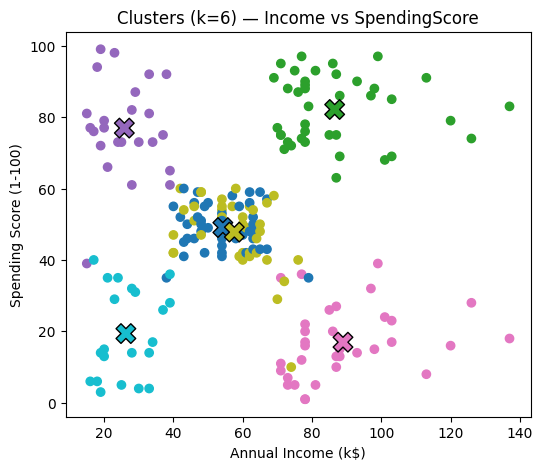

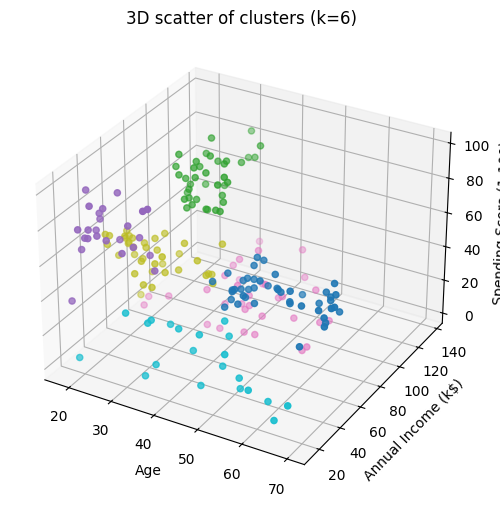


Comparing with scikit-learn KMeans (n_init=10, kmeans++ init)
sklearn inertia: 133.868, n_iter: 6, runtime: 0.033s


,Age,Annual Income (k$),Spending Score (1-100),cluster
0,56.333333,54.266667,49.066667,0
1,26.794872,57.102564,48.128205,1
2,41.939394,88.939394,16.969697,2
3,32.692308,86.538462,82.128205,3
4,25.000000,25.260870,77.608696,4
5,45.523810,26.285714,19.380952,5


In [17]:
#  Run final K-Means (our implementation) with chosen k

print(f"\nRunning final K-Means (k={final_k}) with kmeans++ init...")
t0 = time.time()
centroids_final, labels_final, iters_final, inertia_final = kmeans_from_scratch(X, final_k, init='kmeans++', random_state=42, verbose=True)
t1 = time.time()
print(f"Completed in {iters_final} iterations, inertia={inertia_final:.3f}, time={(t1-t0):.3f}s")


centroids_orig = scaler.inverse_transform(centroids_final)
centroids_df = pd.DataFrame(centroids_orig, columns=selected)
centroids_df['cluster'] = range(final_k)
print("\nFinal centroids (original units):")
display(centroids_df)


unique, counts = np.unique(labels_final, return_counts=True)
cluster_sizes = pd.DataFrame({'cluster': unique, 'size': counts}).sort_values('cluster').reset_index(drop=True)
print("\nCluster sizes:")
display(cluster_sizes)


clustered_df = X_raw.copy()
clustered_df['cluster'] = labels_final
cluster_averages = clustered_df.groupby('cluster').mean().reset_index().sort_values('cluster')
print("\nCluster averages (original units):")
display(cluster_averages)


print("\nBusiness interpretations (based on cluster averages):")
for _, row in cluster_averages.iterrows():
    cl = int(row['cluster'])
    age_avg = row[selected[0]]
    inc_avg = row[selected[1]]
    sp_avg = row[selected[2]]
    label = f"Cluster {cl} (size={int(cluster_sizes[cluster_sizes.cluster==cl]['size'])}): "
    traits = []

    if age_avg < 30:
        traits.append("young")
    elif age_avg < 50:
        traits.append("middle-aged")
    else:
        traits.append("older")

    if inc_avg < np.percentile(X_raw[selected[1]], 33):
        traits.append("low-income")
    elif inc_avg > np.percentile(X_raw[selected[1]], 66):
        traits.append("high-income")
    else:
        traits.append("mid-income")

    if sp_avg < np.percentile(X_raw[selected[2]], 33):
        traits.append("low-spending")
    elif sp_avg > np.percentile(X_raw[selected[2]], 66):
        traits.append("high-spending")
    else:
        traits.append("mid-spending")
    print(label + ", ".join(traits) + f"  -> (Age: {age_avg:.1f}, Income: {inc_avg:.1f}, SpendingScore: {sp_avg:.1f})")


plt.figure(figsize=(6,5))
plt.scatter(clustered_df[selected[1]], clustered_df[selected[2]], c=labels_final, cmap='tab10')
plt.scatter(centroids_orig[:,1], centroids_orig[:,2], marker='X', s=200, c=range(final_k), cmap='tab10', edgecolor='k')
plt.xlabel(selected[1]); plt.ylabel(selected[2]); plt.title(f"Clusters (k={final_k}) — Income vs SpendingScore")
plt.show()


if X.shape[1] >= 3:
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(clustered_df[selected[0]], clustered_df[selected[1]], clustered_df[selected[2]], c=labels_final, cmap='tab10', depthshade=True)
    ax.set_xlabel(selected[0]); ax.set_ylabel(selected[1]); ax.set_zlabel(selected[2])
    ax.set_title(f"3D scatter of clusters (k={final_k})")
    plt.show()


print("\nComparing with scikit-learn KMeans (n_init=10, kmeans++ init)")
sk_start = time.time()
sk = SKLearnKMeans(n_clusters=final_k, init='k-means++', n_init=10, random_state=42)
sk.fit(X)
sk_end = time.time()
sk_time = sk_end - sk_start

sk_centroids_orig = scaler.inverse_transform(sk.cluster_centers_)
sk_cent_df = pd.DataFrame(sk_centroids_orig, columns=selected)
sk_cent_df['cluster'] = range(final_k)

print(f"sklearn inertia: {sk.inertia_:.3f}, n_iter: {sk.n_iter_}, runtime: {sk_time:.3f}s")
display(sk_cent_df)


In [18]:

print("\nCentroid comparison (ours vs sklearn):")
comp = centroids_df.merge(sk_cent_df, on='cluster', suffixes=('_ours','_sklearn'))
display(comp)


out_assignments = "kmeans_assignments.csv"
clustered_df.to_csv(out_assignments, index=False)
centroids_df.to_csv("kmeans_centroids_ours.csv", index=False)
sk_cent_df.to_csv("kmeans_centroids_sklearn.csv", index=False)
print(f"\nSaved files: {out_assignments}, kmeans_centroids_ours.csv, kmeans_centroids_sklearn.csv")



print("\n=== SUMMARY ===")
print(f"Detected dataset rows: {len(df)}; used rows after dropna: {len(X_raw)}")
print(f"Selected features: {selected}")
print(f"Initialization comparison (k={demo_k}): random avg inertia={np.mean(cmp_res['random']['inertias']):.2f}, kmeans++ avg inertia={np.mean(cmp_res['kmeans++']['inertias']):.2f}")
print(f"Final chosen k = {final_k} (silhouette). Final inertia (ours) = {inertia_final:.3f}. sklearn inertia = {sk.inertia_:.3f}")
print("Complete. Inspect the tables and plots above for justification and interpretation.")


Centroid comparison (ours vs sklearn):


,Age_ours,Annual Income (k$)_ours,Spending Score (1-100)_ours,cluster,Age_sklearn,Annual Income (k$)_sklearn,Spending Score (1-100)_sklearn
0,56.333333,54.266667,49.066667,0,56.333333,54.266667,49.066667
1,32.692308,86.538462,82.128205,1,26.794872,57.102564,48.128205
2,25.250000,25.833333,76.916667,2,41.939394,88.939394,16.969697
3,41.939394,88.939394,16.969697,3,32.692308,86.538462,82.128205
4,26.684211,57.578947,47.789474,4,25.000000,25.260870,77.608696
5,45.523810,26.285714,19.380952,5,45.523810,26.285714,19.380952



Saved files: kmeans_assignments.csv, kmeans_centroids_ours.csv, kmeans_centroids_sklearn.csv

=== SUMMARY ===
Detected dataset rows: 200; used rows after dropna: 200
Selected features: ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
Initialization comparison (k=5): random avg inertia=171.24, kmeans++ avg inertia=175.11
Final chosen k = 6 (silhouette). Final inertia (ours) = 133.868. sklearn inertia = 133.868
Complete. Inspect the tables and plots above for justification and interpretation.
